<a href="https://colab.research.google.com/github/Joanna0512/smog_krakowski/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [2]:
!unzip -q "/content/archive (2).zip" -d data/

In [3]:
all_file_names = glob.glob("data/*2017.csv")

In [4]:
all_file_names

['data/may-2017.csv',
 'data/january-2017.csv',
 'data/march-2017.csv',
 'data/september-2017.csv',
 'data/november-2017.csv',
 'data/july-2017.csv',
 'data/june-2017.csv',
 'data/april-2017.csv',
 'data/february-2017.csv',
 'data/august-2017.csv',
 'data/december-2017.csv',
 'data/october-2017.csv']

In [5]:
jan = pd.read_csv('/content/data/january-2017.csv')
feb = pd.read_csv('/content/data/february-2017.csv')
mar = pd.read_csv('/content/data/march-2017.csv')
apr = pd.read_csv('/content/data/april-2017.csv')
may = pd.read_csv('/content/data/may-2017.csv')
jun = pd.read_csv('/content/data/june-2017.csv')
jul = pd.read_csv('/content/data/july-2017.csv')
aug = pd.read_csv('/content/data/august-2017.csv')
sep = pd.read_csv('/content/data/september-2017.csv')
octo = pd.read_csv('/content/data/october-2017.csv')
nov = pd.read_csv('/content/data/november-2017.csv')
dec = pd.read_csv('/content/data/december-2017.csv')
sensor_loc = pd.read_csv('/content/data/sensor_locations.csv')

In [6]:
year = pd.concat([jan, feb, mar, apr, may, jun, jul, aug, sep, octo, nov, dec])

In [7]:
year["UTC time"] = pd.to_datetime(year["UTC time"], format="%Y-%m-%dT%H:%M:%S")
year = year.set_index("UTC time")

In [8]:
columns_pm10 = [ i  for i in year.columns if  i.split("_")[1] == "pm10"]
year_pm10 = year[columns_pm10]
year_pm10[:3]

,3_pm10,140_pm10,142_pm10,147_pm10,169_pm10,170_pm10,171_pm10,172_pm10,173_pm10,174_pm10,...,225_pm10,226_pm10,227_pm10,228_pm10,263_pm10,622_pm10,713_pm10,808_pm10,857_pm10,895_pm10
UTC time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,NaN,NaN,196.0,346.0,229.0,277.0,256.0,219.0,205.0,212.0,...,477.0,346.0,171.0,322.0,235.0,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:00:00,NaN,NaN,180.0,330.0,230.0,247.0,228.0,226.0,227.0,238.0,...,482.0,308.0,177.0,250.0,203.0,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:00:00,NaN,NaN,189.0,333.0,201.0,203.0,240.0,224.0,213.0,264.0,...,474.0,277.0,193.0,237.0,162.0,NaN,NaN,NaN,NaN,NaN


Sprawdzam, któy sesnor ma najmniejszą ilością nulli

In [9]:
year_pm10.isnull().sum().sort_values(ascending=True).index[0]

'212_pm10'

In [10]:
year_pm10_212 = year_pm10["212_pm10"]

In [11]:
"ilość brakujących obserwacji", year_pm10_212.isnull().sum()

('ilość brakujących obserwacji', 8)

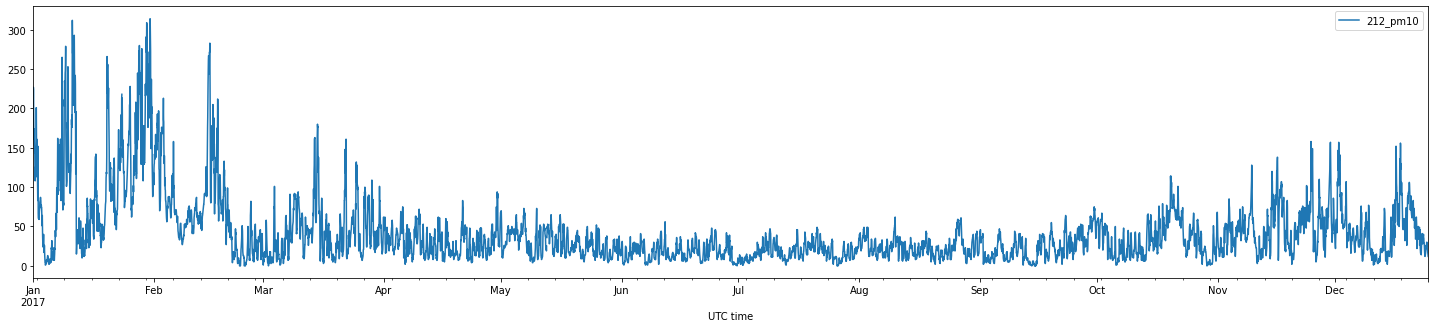

In [12]:
year_pm10_212.plot(figsize=(25,5), legend=True, subplots=True)
plt.show()

     

Uzupełnianie brakujących danych poprzez interpolacje

In [15]:
year_pm10_212.interpolate(method='linear', axis=0, inplace=True)

In [14]:
"ilość nulli po interpolacji",year_pm10_212.isnull().sum().sum()

('ilość nulli po interpolacji', 0)

LSTM Models

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [16]:
"Długość indexu ze zbioru", len(year_pm10_212.index)

('Długość indexu ze zbioru', 8593)

In [18]:
"pożądana długość indexu ", len(pd.date_range(start=year_pm10_212.index.min(), end=year_pm10_212.index.max(), freq='1H'))

('pożądana długość indexu ', 8593)

In [33]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
# podział sekwencji na próbki
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# znajdź koniec
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [27]:
# sekwencja wejściowa
raw_seq = year_pm10_212.values

In [28]:
# n_steps = 168  # ostatni tydzień 7 x 24h 
n_steps = 3

In [29]:
# podziel na próbki
X, y = split_sequence(raw_seq, n_steps)
X.shape, y.shape

((8590, 3), (8590,))

In [30]:
# reshape
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [34]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=["accuracy"])

EarlyStop = EarlyStopping(monitor='val_loss', 
                          patience=5,
                          verbose=1)
history = model.fit(X, 
                    y, 
                    epochs=200, 
                    batch_size=64, 
                    validation_split=0.2,)
scores = model.evaluate(X, y)
print(f"Accuracy {scores[1] * 100}")

Epoch 1/200
108/108 [==============================] - 37s 6ms/step - loss: 888.2898 - accuracy: 0.0045 - val_loss: 139.3775 - val_accuracy: 0.0023
Epoch 2/200
108/108 [==============================] - 0s 4ms/step - loss: 120.0592 - accuracy: 0.0068 - val_loss: 93.7193 - val_accuracy: 0.0023
Epoch 3/200
108/108 [==============================] - 0s 4ms/step - loss: 104.3578 - accuracy: 0.0077 - val_loss: 84.9630 - val_accuracy: 0.0029
Epoch 4/200
108/108 [==============================] - 0s 4ms/step - loss: 103.1868 - accuracy: 0.0080 - val_loss: 83.8610 - val_accuracy: 0.0035
Epoch 5/200
108/108 [==============================] - 0s 4ms/step - loss: 101.0072 - accuracy: 0.0080 - val_loss: 82.2511 - val_accuracy: 0.0035
Epoch 6/200
108/108 [==============================] - 0s 4ms/step - loss: 101.5096 - accuracy: 0.0080 - val_loss: 75.8358 - val_accuracy: 0.0035
Epoch 7/200
108/108 [==============================] - 0s 4ms/step - loss: 96.5602 - accuracy: 0.0080 - val_loss: 74.8956 

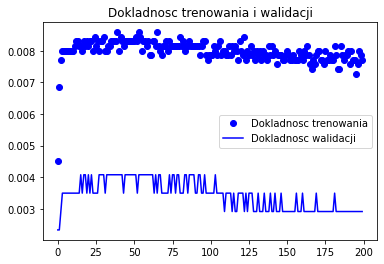

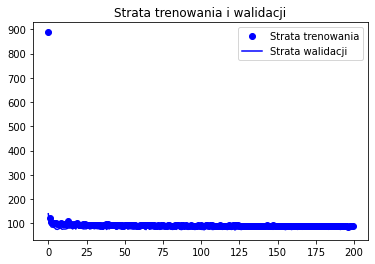

In [35]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Dokladnosc trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokladnosc walidacji')
plt.title('Dokladnosc trenowania i walidacji')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()